In [27]:
import torch
import time
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from networks.ensemble import Ensemble
import numpy as np
from scipy import ndimage
import random
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plot

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

PRETRAINING = True
ENSEMBLE_MEMBER = 1
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = Ensemble(size=3, output_size=5, lr=15e-4, learning_decay=0.7, decay_step=1, threshold=9.0, weight_decay=1e-4, new_model=True)

ensemble.load_ensemble("../checkpoints/ensembles/01-20-23-baseline", full=True)
# ensemble.load_ensemble("../checkpoints/ensembles/01-24-23-baseline-HIL-B", full=True)
ensemble.eval_mode()

# sampled_dataset = SwarmDataset("../data/full-mini", rank=0)
sampled_dataset = SwarmDataset("../data/validation-easy-model", rank=0)
data = sampled_dataset

embeddings = []
classes = []
# for i in range(len(data)):
for i in range(200):
    image, _class = sampled_dataset[i][0], sampled_dataset[i][1][0]
    image = np.expand_dims(image, axis=0)
    embed = ensemble.ensemble[ENSEMBLE_MEMBER].forward(torch.tensor(image, device=device, dtype=torch.float))
    embed = embed.detach().cpu().squeeze(dim=0).numpy()
    embeddings.append(embed)
    classes.append(_class)

embeddings = np.array(embeddings)
reduced = TSNE(
    n_components=2,
    learning_rate="auto",
    init="pca",
    perplexity=40,
    early_exaggeration=1
).fit_transform(embeddings)

Adjusting learning rate of group 0 to 1.5000e-03.
Adjusting learning rate of group 0 to 1.5000e-03.
Adjusting learning rate of group 0 to 1.5000e-03.


/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


200
200


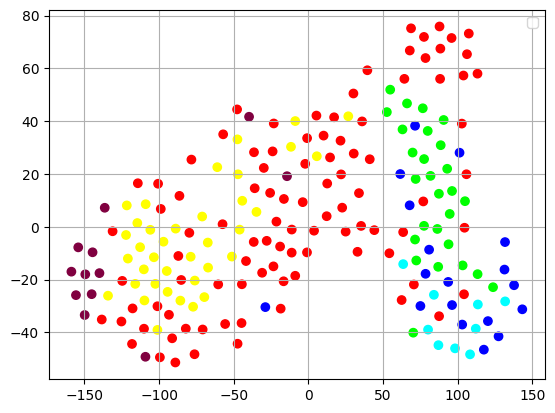

In [28]:
def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

color_classes = {
    -1: [0.33, 0.33, 0.33],
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
    3: [0, 1, 1], # Cyan
    4: [1, 1, 0], # Yellow
    5: [0.5, 0, 0.25] # Pink
}

label_classes = {
    -1: "Unlabeled",
    0: "Random",
    1: "Cyclic Pursuit",
    2: "Milling",
    3: "Aggregation",
    4: "Dispersal",
    5: "Wall Following"
}

lim = len(reduced)
print(lim)
classes = [-1 for i in range(lim)]

OUT = "../data/oracle"
# LABELS = "original-hand-labeled-classes.txt"
LABELS = "validation-data-baseline.txt"
with open(os.path.join(OUT, LABELS), "r") as f:
    lines = f.readlines()
    print(len(lines))
    for line in lines:
        triplet = CSVLineToVec(line)
        classes[int(triplet[0])] = int(triplet[1])

x = [reduced[i][0] for i in range(lim)]
y = [reduced[i][1] for i in range(lim)]
colors = [color_classes[classes[i]] for i in range(lim)]
labels = [label_classes[classes[i]] for i in range(lim)]
plot.grid(True)
# plot.xlim(-5000, 20000)
# plot.ylim(-15000, 10000)
plot.scatter(x, y, c=colors)
plot.legend()